In [1]:
library(grid)
library(rpart)
library(rpart.plot)
library(partykit)
library(lattice)
library(ggplot2)
library(caret)

In [2]:
set.seed(1)

In [3]:
jRoadType <- c("都市間高速", "都市高速", "有料道路", "国道", "県道", "主要地方道", "一般道1、一般道2、一般道3", "その他")
jHighSpeeds <- c("都市間高速", "都市高速", "有料道路")

In [4]:
printf <- function(...) cat(sprintf(...))

In [5]:
# valid columns when high speed
invalids1 <- c('Time', 'Longitude', 'Latitude', 'Brake', 'Accel', 'Curve100', 'RoadType', 'flag')
# valid columns when not high speed
invalids2 <- c('Time', 'Longitude', 'Latitude', 'Brake', 'Accel', 'Curve150', 'RoadType', 'flag')

In [6]:
CV <- function(dfx, expr, verbose=FALSE) {        
    folds <- createFolds(dfx$flag)
    
    count <- 1
    errs <- c()
    for (ids in folds) {
        train <- dfx[-ids, ]
        test <- dfx[ids, ]
        fit <- rpart(expr, data=train, method="class")
        p <- predict(fit, newdata=test)
        predictedFlags <- colnames(p)[max.col(p, ties.method = "first")]
        
        if (verbose) {            
            printf("Fold%d\n", count)
            correctVsPredict(test, predictedFlags)
            count <- count + 1
            printf("\n")
        }
        
        nerr <- sum((predictedFlags == test$flag) == FALSE)
        errs <- c(errs, nerr / nrow(test))
    }
    
    return(mean(errs))
}

In [7]:
correctVsPredict <- function(test, predictedFlags) {    
    # for All
    # nTests <- nrow(test)
    # nCorrectAll <- sum((predictedFlags == test$flag) == TRUE)
    # printf("As fo All: correct/all = %d/%d = %f\n", nCorrectAll, nTests, nCorrectAll / nTests)
    
    # for Red
    predictedRedRows <- test[predictedFlags == "Red", ]
    nCorrectReds <- sum((predictedRedRows$flag == 'Red') == TRUE)
    nPredictedReds <- nrow(predictedRedRows)
    printf("As for A: correct/predict = %d/%d = %f\n", nCorrectReds, nPredictedReds, nCorrectReds / nPredictedReds)
    
    # for Blue
    predictedBlueRows <- test[predictedFlags == "Blue", ]
    nCorrectBlues <- sum((predictedBlueRows$flag == 'Blue') == TRUE)
    nPredictedBlues <- nrow(predictedBlueRows)
    printf("As for B: correct/predict = %d/%d = %f\n", nCorrectBlues, nPredictedBlues, nCorrectBlues / nPredictedBlues)
}

In [8]:
printRedRatios <- function(dfx) {
    nRed <- nrow(dfx[dfx$flag == "Red", ])
    nAll <- nrow(dfx)
    printf("Red/All = %d/%d = %f\n", nRed, nAll, nRed/nAll)
    printf("1 - Red/All = %d/%d = %f\n", nAll - nRed, nAll, 1 - nRed/nAll)
}

In [9]:
createFormula <- function(invalids, allFeatures) {
    isValidColumn <- function(x) ! x %in% invalids
    
    features <- Filter(isValidColumn, allFeatures)
    return(paste("flag ~ ", paste(features, collapse=" + ")))
}

# Predict Reds

In [10]:
df3 <- read.csv("../data/middle/sp2.csv", stringsAsFactors=FALSE)

In [11]:
df3$flag[df3$flag == "RedA"] <- "Red"
df3$flag[df3$flag == "RedB"] <- "Red"
df3$flag[df3$flag == "BlueA"] <- "Blue"
df3$flag[df3$flag == "BlueB"] <- "Blue"
df3$flag <- as.factor(df3$flag)

In [12]:
allFeatures <- c(colnames(df3))

In [13]:
roadTypes <- unique(df3$RoadType)

In [14]:
for (i in roadTypes) {
    printf("RoadType: %d (%s)\n", i, jRoadType[i+1])
    dfx <- df3[df3$RoadType == i, ]
    
    if (jRoadType[i+1] %in% c("都市間高速", "都市高速", "有料道路")) {
        expr <- createFormula(invalids1, allFeatures)    
    } else {
        expr <- createFormula(invalids2, allFeatures)    
    }
    
    cv <- CV(dfx, expr, verbose=FALSE)
    printRedRatios(dfx)
    printf("CV value: %f", cv)
    printf("\n\n")
}

RoadType: 7 (その他)
Red/All = 25/27 = 0.925926
1 - Red/All = 2/27 = 0.074074
CV value: 0.066667

RoadType: 6 (一般道1、一般道2、一般道3)
Red/All = 90/189 = 0.476190
1 - Red/All = 99/189 = 0.523810
CV value: 0.380994

RoadType: 4 (県道)
Red/All = 36/71 = 0.507042
1 - Red/All = 35/71 = 0.492958
CV value: 0.499405

RoadType: 5 (主要地方道)
Red/All = 154/303 = 0.508251
1 - Red/All = 149/303 = 0.491749
CV value: 0.441828

RoadType: 3 (国道)
Red/All = 202/324 = 0.623457
1 - Red/All = 122/324 = 0.376543
CV value: 0.441288

RoadType: 0 (都市間高速)
Red/All = 55/81 = 0.679012
1 - Red/All = 26/81 = 0.320988
CV value: 0.470437

RoadType: 2 (有料道路)
Red/All = 31/47 = 0.659574
1 - Red/All = 16/47 = 0.340426
CV value: 0.230000



In [15]:
fit3 <- rpart(expr, data=df3, method="class")

In [17]:
printcp(fit3)


Classification tree:
rpart(formula = expr, data = df3, method = "class")

Variables actually used in tree construction:
 [1] AccelerationSpeed AheadDistance     Curve150          DistManBicycle   
 [5] DistSignal        LaneCount         RiskFactor        Speed            
 [9] TimeHeadway       TimeToCollision  

Root node error: 449/1042 = 0.4309

n= 1042 

        CP nsplit rel error  xerror     xstd
1 0.031180      0   1.00000 1.00000 0.035602
2 0.023385      6   0.81069 0.93541 0.035265
3 0.018931      8   0.76392 0.95100 0.035357
4 0.013363     10   0.72606 0.91091 0.035106
5 0.010000     14   0.67261 0.92205 0.035180


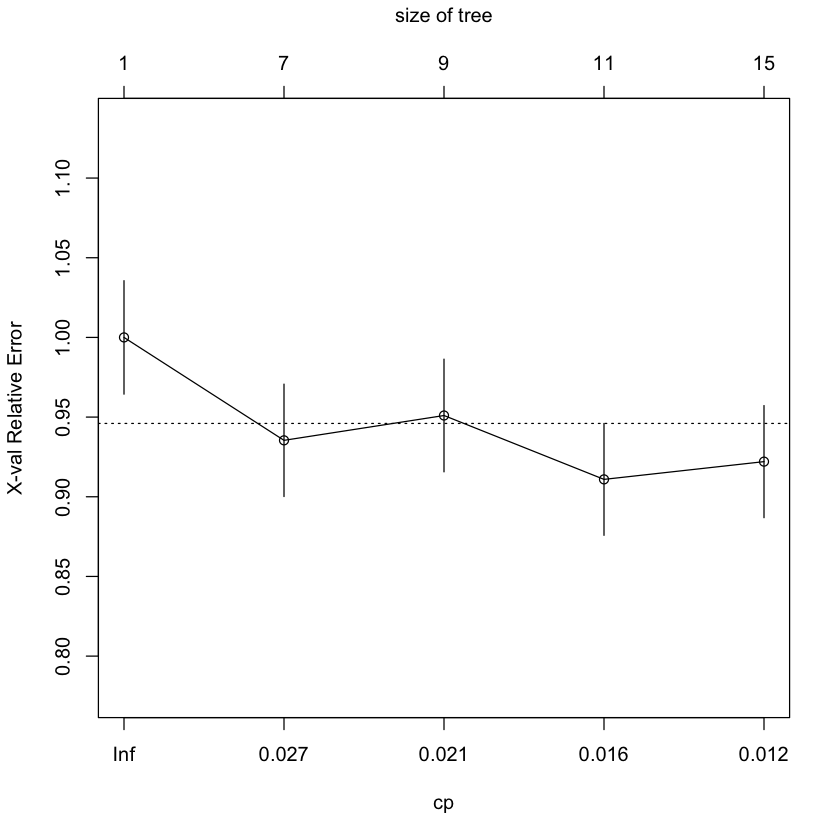

In [23]:
plotcp(fit3)

In [16]:
summary(fit3)

Call:
rpart(formula = expr, data = df3, method = "class")
  n= 1042 

          CP nsplit rel error    xerror       xstd
1 0.03118040      0 1.0000000 1.0000000 0.03560167
2 0.02338530      6 0.8106904 0.9354120 0.03526465
3 0.01893096      8 0.7639198 0.9510022 0.03535667
4 0.01336303     10 0.7260579 0.9109131 0.03510616
5 0.01000000     14 0.6726058 0.9220490 0.03518032

Variable importance
       RiskFactor             Speed       TimeHeadway   TimeToCollision 
               11                11                11                10 
    AheadDistance        DistSignal AccelerationSpeed          Curve150 
               10                 8                 8                 8 
            Curve         LaneCount            Engine    DistManBicycle 
                6                 3                 3                 3 
    SteeringAngle             Pitch   ManBicycleCount        ManBicycle 
                2                 1                 1                 1 
         PathType  

In [21]:
df3

Time,Longitude,Latitude,Speed,Brake,Accel,Engine,AheadDistance,Curve150,Curve100,⋯,Pitch,DistSignal,PathType,LaneCount,AccelerationSpeed,Jerk,TimeHeadway,TimeToCollision,RiskFactor,flag
46.6,139.3192,35.42601,16.28,0,-1,1393.750,0.0,255,255,⋯,0.000000000,860.85420,6,0,-0.09444444,6.111111e-01,0.0000000,0.0000000,0.0000000,Red
61.1,139.3192,35.42601,10.16,0,-1,1446.875,3.2,255,255,⋯,0.000000000,860.85420,6,0,0.48333333,7.777778e-01,0.7595875,-0.8903025,-3.1763510,Red
80.5,139.3202,35.42612,13.51,0,-1,1525.000,0.0,255,255,⋯,0.000497512,770.12409,6,0,0.36666667,1.055556e+00,0.0000000,0.0000000,0.0000000,Red
92.3,139.3203,35.42602,6.05,0,-1,1053.125,0.0,255,255,⋯,0.000000000,761.46473,6,0,0.72222222,3.888889e-01,0.0000000,0.0000000,0.0000000,Red
109.5,139.3203,35.42583,12.49,0,-1,1771.875,0.0,255,255,⋯,0.000000000,768.26741,6,0,0.49444444,9.444444e-01,0.0000000,0.0000000,0.0000000,Red
125.3,139.3207,35.42624,26.87,0,-1,1459.375,0.0,251,107,⋯,0.341791045,723.58887,6,0,0.38888889,2.777778e-01,0.0000000,0.0000000,0.0000000,Red
130.9,139.3210,35.42655,31.13,0,-1,1553.125,0.0,251,251,⋯,0.693034826,686.88766,6,0,0.16111111,5.555556e-01,0.0000000,0.0000000,0.0000000,Red
136.7,139.3215,35.42684,34.09,0,-1,1221.875,0.0,251,251,⋯,0.686567164,639.32459,0,0,0.38888889,3.333333e-01,0.0000000,0.0000000,0.0000000,Blue
172.2,139.3247,35.42829,34.34,0,-1,1365.625,0.0,84,251,⋯,-0.053731343,360.35960,6,0,0.52777778,2.166667e+00,0.0000000,0.0000000,0.0000000,Red
218.1,139.3274,35.42799,33.07,0,-1,1190.625,0.0,124,67,⋯,0.367164179,123.06007,6,0,-0.34444444,1.666667e-01,0.0000000,0.0000000,0.0000000,Blue
